# CS 7324-400B: Lab Three - Extending Logistic Regression
#### Fall 2023
#### Author: Davis Vercher (49377022)

##### References & Citations
- **Download Link:**
    - https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation
- **Sources:** 
    - Analytics Vidhya webstie https://datahack.analyticsvidhya.com/contest/all/
       - Analytics Vidhya is a datascience competition site. The Kaggle author does not cite the exact link to the original Analytics Vidhya competition in their Kaggle post, but rather just mentions that this dataset was a past competition on the Analytics Vidhya site.

## 1. Preparation & Overview

### 1a. Task and Use Case
I am using a dataset from a fictional car company that is launching in a new market. Using existing customer segmentation data from their live markets, this company has categorized a list of ~8,000 existing customers into four segments (labeled A, B, C, & D). These segments will be used in a deployed model in the new market that will help the car company predict what segment a new customer is in based on basic information they give to the company. This segmentation information could then be used for targeted marketing and incentives offered to increase the likelihood that that individual will buy a car. Ultimately, this will allow the car company to interact| with new customers in this new market as if they had already been operating in that market for years. This is an enormously valuable capability for the company.

*Note:* As a digital marketing technology consultant, the client companies I work for are keenly interested in customer segmentation based on digital behaviors, and most have adopted robust AI-enabled segmentation tools that allow them to make quick (and accurate) assumptions about who a new individual customer is and what will drive them to spend with the company. 

### 1b. Define & Prepare Class Variables 

#### 1b1. Initial Investigation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('customer_segment_database.csv')
print(len(df)); df.head()

8068


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
print(df.dtypes)

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object


#### 1b2. Columns and definitions
- **ID:** a unique customer ID number that is a six-digit integer
- **Gender:** a binary classification for female and male
- **Ever_Married:** a binary classification (yes/no) for if the individual has ever been married
- **Age:** the age of the individual (as an integer)
- **Graduated:** a binary classification (yes/no) for if the indvidual has graduated
   -*Note:* It is not clear in the dataset what they have or have not graduated from (i.e., high school, )undergraduate, graduate, etc.
- **Profession:** the profession of the individual, expressed as a string (i.e., "Engineer")
- **Work_Experience:** the number of years of work experience the individual has (as a float)
- **Spending_Score:** the spending range category the customer has been placed in (Low, Average, or High)
- **Family_Size:** the number of people in the individual's family (including them). Expressed as a float.
- **Var_1:** an unexplained external variable (this will be dropped due to a lack of documentation in the Kaggle post... I am not sure what this variable is).
- **Segmentation:** what segment the individual belongs to. This is the target variable

#### 1b3. Dropping Unecessary Columns
I will drop the following column (with reasons as to why)
- **Var_1:** Because it is not explained what this is, I am dropping this column. Even though I will be reducing the total information in the dataset by dropping this column, if 'Var_1' proves to be decisive in the creation of the model, I cannot draw any insights as to why without knowing anything about 'Var_1'

In [4]:
df = df.drop(columns=['Var_1'])
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,A


In [5]:
print(df.duplicated().sum())

0


Now that I know there are no duplicate rows (since each row has a unique identifier from the 'ID' column), I will now drop the ID column. If for some reason I needed to keep the information about unique individuals for later, I would not do so. However, since I do not need this information to train my classifier, I will drop this information.

In [6]:
df = df.drop(columns=['ID'])
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,A


#### 1b4. Handling Null Values

Because there are zero duplicated entires, we can move on to evaluating null values column by column.

In [7]:
sum_nan = df.isna().sum()
print(sum_nan)

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Segmentation         0
dtype: int64


I'll first visualize the missing values:

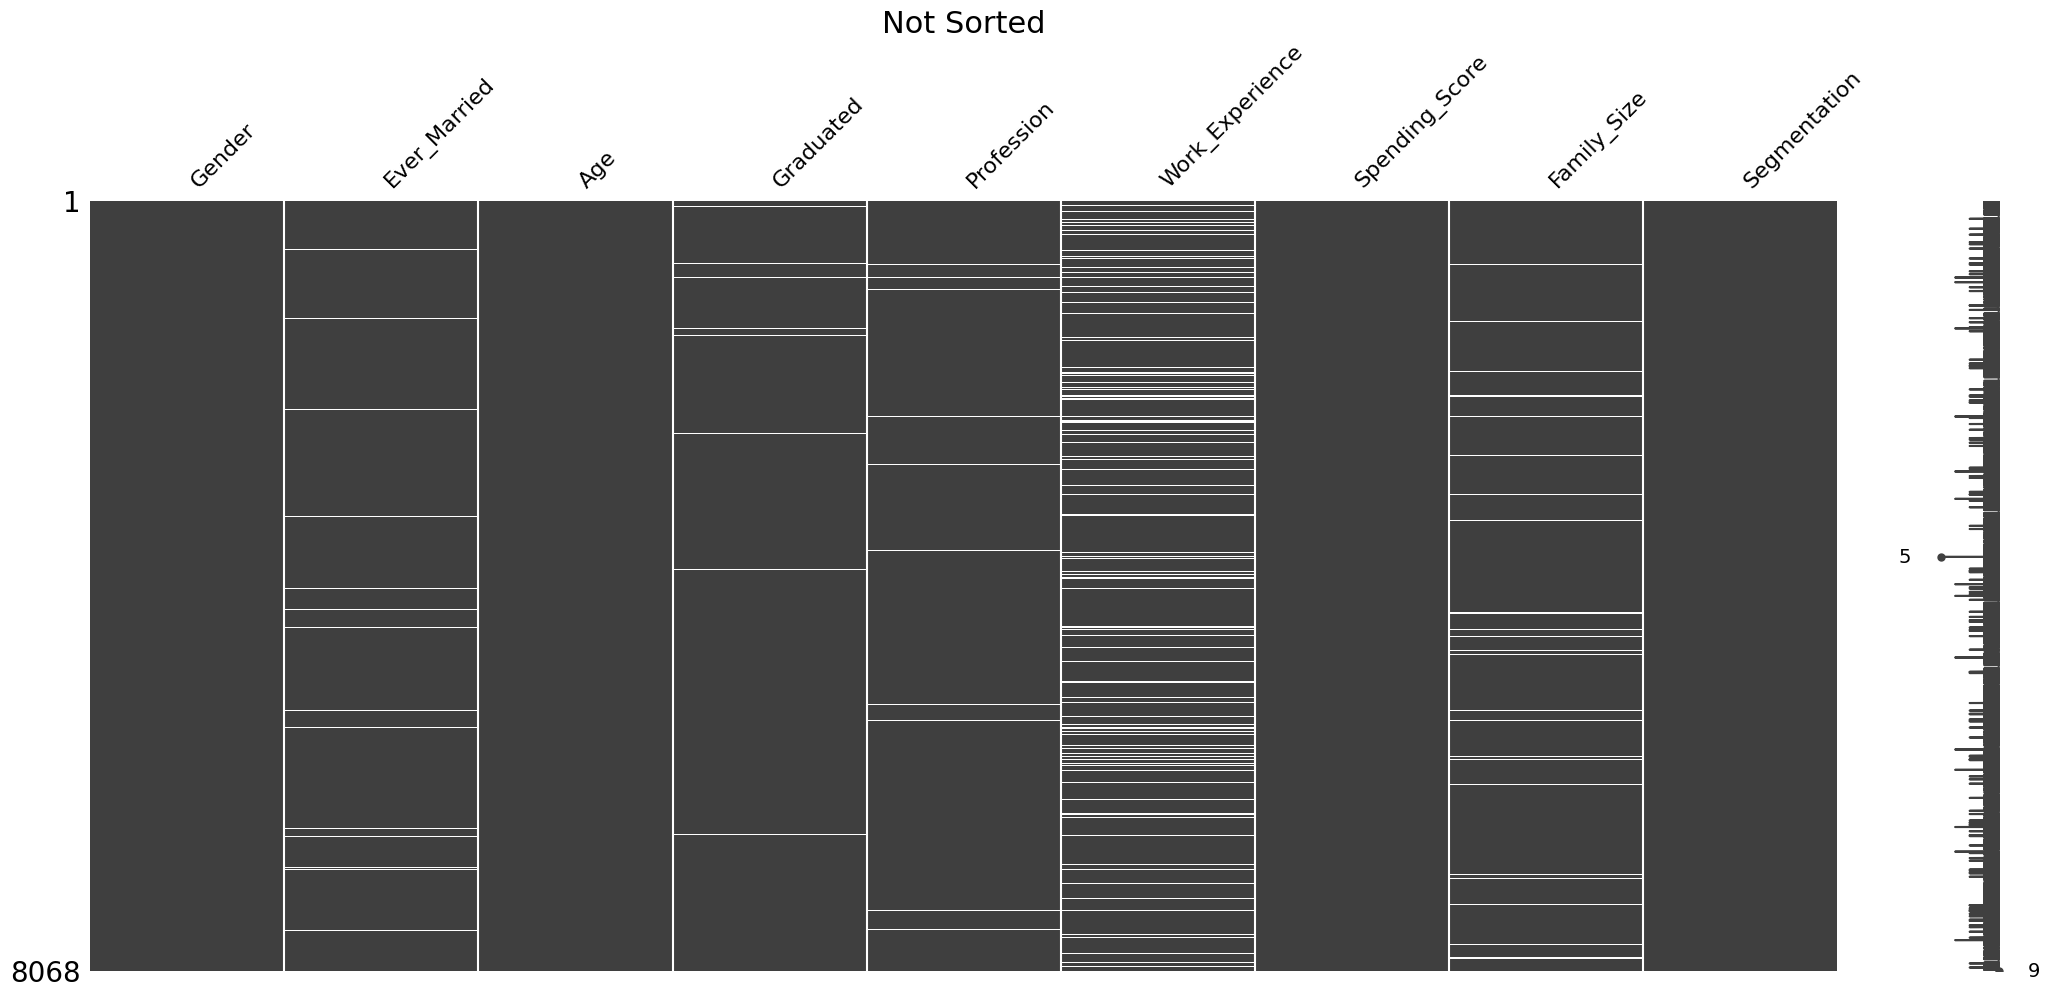

In [8]:
import missingno as mn
import matplotlib.pyplot as plt
%matplotlib inline

mn.matrix(df)
plt.title("Not Sorted", fontsize=22)
plt.show()

It appears that there is not a significant amount of entries with null values for Ever_Married, Graduated, Profession, adn Family_Size, so I will delete the entries with null values in any of those columns.

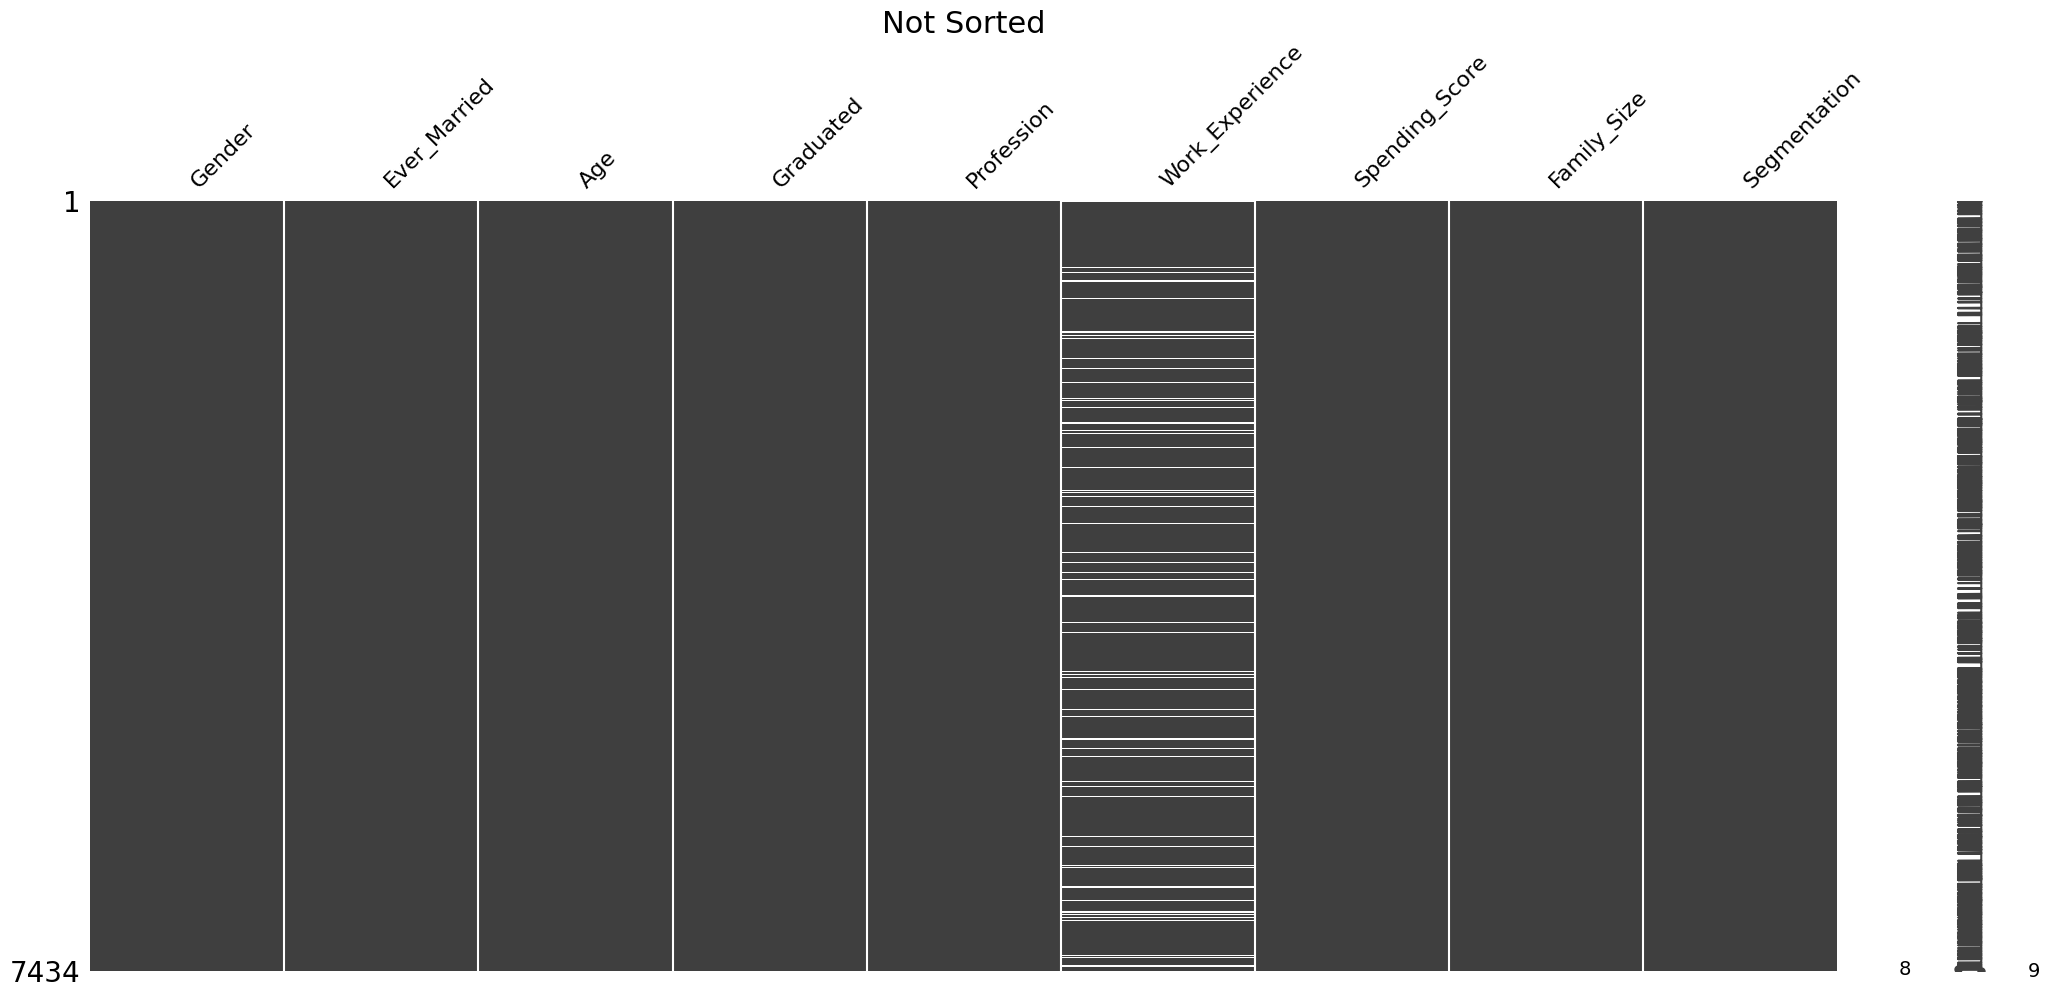

In [9]:
df.dropna(subset=['Ever_Married', 'Graduated', 'Profession', 'Family_Size'], inplace=True)

mn.matrix(df)
plt.title("Not Sorted", fontsize=22)
plt.show()

With nearly ten percent of the remaining entries having a null value Work_Experience, I am hestitant to drop every row with a null value in that column. However, because the number of years of work experience could vary realistically between 0 and 50 years, and because there is no way to realistically impute this value from the other data in the other columns, I am choosing to drop these null entries.

In [10]:
df = df.dropna(subset=['Work_Experience'])
df = df.reset_index(drop=True)
print(df.isna().sum())

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Segmentation       0
dtype: int64


#### 1b5. Optimizing Datatypes

Before I begin changing datatypes and one-hot-encoding, I will separate out my target column ('Segmentation') from the rest of the df. This way, I can more easily change the dtypes of the remaining 'X' columns.

In [11]:
y = df['Segmentation']
X = df.drop(['Segmentation'], axis=1)

In [12]:
print(X.dtypes)

Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
dtype: object


In [13]:
X.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
2,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
3,Male,Yes,56,No,Artist,0.0,Average,2.0
4,Male,No,32,Yes,Healthcare,1.0,Low,3.0


In [14]:
X['Gender'] = X['Gender'].map({'Female': 0, 'Male': 1})
X['Ever_Married'] = X['Ever_Married'].map({'No': 0, 'Yes': 1})
X['Graduated'] = X['Graduated'].map({'No': 0, 'Yes': 1})

X['Work_Experience'] = X['Work_Experience'].astype(int, errors='ignore')
X['Family_Size'] = X['Family_Size'].astype(int, errors='ignore')

X = pd.get_dummies(X, columns=['Profession', 'Spending_Score'], drop_first=False).astype(int)
#I am deliberately not using implicit coding with these one-hot-encodings for simplicity

In [15]:
print(X.dtypes)

Gender                      int32
Ever_Married                int32
Age                         int32
Graduated                   int32
Work_Experience             int32
Family_Size                 int32
Profession_Artist           int32
Profession_Doctor           int32
Profession_Engineer         int32
Profession_Entertainment    int32
Profession_Executive        int32
Profession_Healthcare       int32
Profession_Homemaker        int32
Profession_Lawyer           int32
Profession_Marketing        int32
Spending_Score_Average      int32
Spending_Score_High         int32
Spending_Score_Low          int32
dtype: object


In [16]:
X.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low
0,1,0,22,0,1,4,0,0,0,0,0,1,0,0,0,0,0,1
1,0,1,67,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1
2,1,1,67,1,0,2,0,0,0,0,0,0,0,1,0,0,1,0
3,1,1,56,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0
4,1,0,32,1,1,3,0,0,0,0,0,1,0,0,0,0,0,1


I have now made the following dtypes changes:
- Changed the binary categories (Gender, Ever_Married, and Graduated) to integer binary values (0 or 1)
- Changed the numeric values for Work_Experience and Family_Size from floats to integers
- One-hot-encoded the categorical columns (Profession, Spending_Score, & Segmentation) into integer boolean values

#### 1b6. Post Preprocessing Breakdown

In [17]:
pd.set_option('display.max_columns', None)
print(X.describe())
pd.reset_option('display.max_columns')

            Gender  Ever_Married          Age    Graduated  Work_Experience  \
count  6718.000000   6718.000000  6718.000000  6718.000000      6718.000000   
mean      0.551057      0.591694    43.524263     0.636797         2.629652   
std       0.497423      0.491557    16.513115     0.480959         3.404639   
min       0.000000      0.000000    18.000000     0.000000         0.000000   
25%       0.000000      0.000000    31.000000     0.000000         0.000000   
50%       1.000000      1.000000    41.000000     1.000000         1.000000   
75%       1.000000      1.000000    53.000000     1.000000         4.000000   
max       1.000000      1.000000    89.000000     1.000000        14.000000   

       Family_Size  Profession_Artist  Profession_Doctor  Profession_Engineer  \
count  6718.000000        6718.000000        6718.000000          6718.000000   
mean      2.841768           0.329116           0.088419             0.087228   
std       1.523319           0.469927        

***Key takeaways from X:***
- **Gender:** ~55% of the individuals in the data are male
- **Ever_Married:** ~59% of individuals are or have been married
- **Age:**
   - The average age is 43
   - The minimum age is 18
   - The maximum age is 89
- **Work_Experience:**
   - The average length of work experience is 2.63 years
   - The longest length of work experience is 14 years
- **Professions:** Each profession has the following percentage of the data:
   - Artist: 32.9%
   - Doctor: 8.8%
   - Engineer: 8.7%
   - Entertainment: 12.1%
   - Executive: 7.6%
   - Healthcare: 16.2%
   - Homemaker: 2.6%
   - Lawyer: 7.5%
   - Marketing: 3.5%
- **Spending_Score:** Each spending score bucket has the following percentage of the data:
   - Low: 60.0%
   - Average: 25.0%
   - High: 15.0%

In [18]:
y.value_counts()

Segmentation
D    1772
C    1735
A    1628
B    1583
Name: count, dtype: int64

*Key takeaways from y:*
- Each of the four output categories are relatively equal in size, and command approximatley 25% of the dataset each

### 1c. Divide Data (Train / Test Split)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [20]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=17)

In [21]:
# 5 folds (simulated 80/20 split)
scores = cross_val_score(model, X, y, cv=5)

for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

Fold 1: 0.5231
Fold 2: 0.5126
Fold 3: 0.5126
Fold 4: 0.5138
Fold 5: 0.5078


In [22]:
# 3 folds (simulated 66/33 split)
scores = cross_val_score(model, X, y, cv=3)

for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

Fold 1: 0.5201
Fold 2: 0.5078
Fold 3: 0.5087


In [23]:
# 10 folds (simulated 90/10 split)
scores = cross_val_score(model, X, y, cv=10)

for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

Fold 1: 0.5149
Fold 2: 0.5372
Fold 3: 0.5223
Fold 4: 0.5208
Fold 5: 0.5223
Fold 6: 0.5015
Fold 7: 0.5015
Fold 8: 0.5298
Fold 9: 0.4933
Fold 10: 0.5320


The accuracy scores for simulated 80/20, 66/33, and 90/10 splits are all relativley similar (~50%). I cannot determine definitively which kind of split would be best suited for my purposes.

- Arguments for 80/20 split:
   - Common "default" convention is an 80/20 split
   - Splitting my data 80/20 yields 5,374 training rows and 1,344 test rows. This is a sizeable enough group for both categories to provide ample training and testing.
   - All three simulated split sizes above using cross-validation scores yielded relativley the same result. With 4 output classes of equal size (each of the four segments owns roughly 25% of the dataset), a 50% score seen from cross-validation means that the basic model is more accurate than random guess -- which would be around 25% accurate). This means that it would not be advantageous to use a different split than 80/20.

- Arguments against 80/20 split:
   - If my dataset was not split relatively equally between the four target classes, an 80/20 split without any additional processing to equalize the classes could result in skewed results
   - An 80/20 split may prove to be unable to minimize overfitting if the nature of my dataset requires a more equal split (i.e., 60/40 or 70/30)

## 2. Modeling

### 2a. Custom one-versus-all logistic regression classifier

#### 2a1. Template from instructor
Credit for the below templates:
- https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb
- https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.special import expit

In [25]:
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

In [26]:
blr = BinaryLogisticRegressionBase(0.1)
print(blr)

Base Binary Logistic Regression Object, Not Trainable


In [27]:
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_intercept=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

In [28]:
blr = BinaryLogisticRegression(0.1)
print(blr)

Untrained Binary Logistic Regression Object


In [29]:
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)

In [30]:
class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,
                                                 self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

In [31]:
lr = LogisticRegression(0.1,1500)
print(lr)

Untrained MultiClass Logistic Regression Object


In [32]:
y_np = y.to_numpy()

#### 2a2. Base template LR accuracy

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_np, train_size = 0.8, test_size=0.2)

lr = LogisticRegression(0.1,500)
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.30431547619047616


#### 2a3. SciKit-Learn LR accuracy

In [34]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

In [35]:
lr_sk = SKLogisticRegression(solver='liblinear') # all params default

lr_sk.fit(X_train,y_train)
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.5230654761904762


It appears that the sklearn logistic regression provides me with a slightly better accuracy. However, when I run the "base template" logistic regression, the accuracy scores vary widely between roughly random chance (25% accuracy since there are 4 output classes) and 45%. I am not sure what is causing this variance, or why it is so different than the sklearn logistic regression.

#### 2a4. Adding functionality to the template classifier
I have used ChatGPT-4 to help me understand how to do this. You can find my conversation with ChatGPT-4 here: https://chat.openai.com/share/b2bdc307-eccc-4063-87ca-d467a3578e48

Updating the 'VectorBinaryLogisticRegression' and 'LogisticRegression' classes to add the optimization technique selection functionality:

In [36]:
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, eta, iterations=20, technique='steepest'):
        super().__init__(eta, iterations)
        self.technique = technique
        if technique not in ['steepest', 'stochastic', 'newton']:
            raise ValueError("Optimization technique should be 'steepest', 'stochastic', or 'newton'")
        
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features,1))
        
        if self.technique == 'steepest':
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb, y)
                self.w_ += gradient * self.eta
                
        elif self.technique == 'stochastic':
            for _ in range(self.iters):
                idx = np.random.randint(0, num_samples)
                gradient = self._get_gradient(Xb[idx].reshape(1, -1), y[idx])
                self.w_ += gradient * self.eta
                
        elif self.technique == 'newton':
            self._newtons_method(Xb, y)

    def _get_gradient(self, X, y):
        ydiff = y-self.predict_proba(X, add_intercept=False).ravel()
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0) 
        return gradient.reshape(self.w_.shape)
    
    def _get_hessian(self, X):
        p = self.predict_proba(X, add_intercept=False).ravel()
        diag_W = p * (1 - p)
        W = np.diag(diag_W)
        return X.T @ W @ X
        
    def _newtons_method(self, X, y):
        for _ in range(self.iters):
            gradient = self._get_gradient(X, y)
            hessian = self._get_hessian(X)
            self.w_ -= np.linalg.pinv(hessian) @ gradient


    
class LogisticRegression:
    def __init__(self, eta, iterations=20, technique='steepest'):
        self.eta = eta
        self.iters = iterations
        self.technique = technique
        if technique not in ['steepest', 'stochastic', 'newton']:
            raise ValueError("Optimization technique should be 'steepest', 'stochastic', or 'newton'")

    def __str__(self):
        if hasattr(self, 'w_'):
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []

        for i, yval in enumerate(self.unique_):
            y_binary = (y == yval)
            blr = VectorBinaryLogisticRegression(self.eta, self.iters, self.technique)
            blr.fit(X, y_binary)
            self.classifiers_.append(blr)

        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X))
        return np.hstack(probs)

    def predict(self, X):
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]


Testing the optimization technique selection functionality

In [37]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest')
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.38764880952380953


In [38]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='stochastic')
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.28422619047619047


In [39]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='newton')
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.08482142857142858


Updating the 'VectorBinaryLogisticRegression' and 'LogisticRegression' classes to add the customizable regularization term and associated cost:

In [40]:
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, eta, iterations=20, technique='steepest', regularization=None, C=1.0):
        super().__init__(eta, iterations)
        self.technique = technique
        self.regularization = regularization
        self.C = C
        
        if technique not in ['steepest', 'stochastic', 'newton']:
            raise ValueError("Optimization technique should be 'steepest', 'stochastic', or 'newton'")
        if regularization not in [None, 'l1', 'l2', 'elasticnet']:
            raise ValueError("Regularization should be None, 'l1', 'l2', or 'elasticnet'")
        
    def fit(self, X, y):
        Xb = self._add_intercept(X)  # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features,1))
        
        if self.technique == 'steepest':
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb, y)
                self.w_ += gradient * self.eta
                
        elif self.technique == 'stochastic':
            for _ in range(self.iters):
                idx = np.random.randint(0, num_samples)
                gradient = self._get_gradient(Xb[idx].reshape(1, -1), y[idx])
                self.w_ += gradient * self.eta
                
        elif self.technique == 'newton':
            self._newtons_method(Xb, y)
            
    def _get_gradient(self, X, y):
        ydiff = y-self.predict_proba(X, add_intercept=False).ravel()
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        
        # Add regularization to the gradient
        if self.regularization == 'l1':
            gradient[1:] += self.C * np.sign(self.w_[1:])
        elif self.regularization == 'l2':
            gradient[1:] += 2 * self.C * self.w_[1:]
        elif self.regularization == 'elasticnet':
            gradient[1:] += self.C * np.sign(self.w_[1:]) + 2 * self.C * self.w_[1:]

        return gradient
    
    def _get_hessian(self, X):
        p = self.predict_proba(X, add_intercept=False).ravel()
        diag_W = p * (1 - p)
        W = np.diag(diag_W)
        return X.T @ W @ X
        
    def _newtons_method(self, X, y):
        for _ in range(self.iters):
            gradient = self._get_gradient(X, y)
            hessian = self._get_hessian(X)
            self.w_ -= np.linalg.pinv(hessian) @ gradient



    
class LogisticRegression:
    def __init__(self, eta, iterations=20, technique='steepest', regularization=None, C=1.0):
        self.eta = eta
        self.iters = iterations
        self.technique = technique
        self.regularization = regularization
        self.C = C
    
    def __str__(self):
        if hasattr(self, 'w_'):
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)  # if we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []  # will fill this array with binary classifiers
        
        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = y == yval  # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta, self.iters, self.technique, self.regularization, self.C)
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X))  # get probability for each classifier
        
        return np.hstack(probs)  # make into a single matrix
    
    def predict(self, X):
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]  # take argmax along row



### 2b. Training

#### 2b1. Finding the best performance with optimization technique and regularizaiton term

***'Steepest' Optimizations***

In [41]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization=None)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.38764880952380953


In [42]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.3898809523809524


In [43]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.42782738095238093


C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


In [44]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='elasticnet', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


Accuracy of:  0.25297619047619047


***'Stochastic' Optimizations***

In [45]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='stochastic', regularization=None)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.32663690476190477


In [46]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='stochastic', regularization='l1', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.31919642857142855


In [47]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='stochastic', regularization='l2', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.3712797619047619


C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


In [48]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='stochastic', regularization='elasticnet', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.24330357142857142


C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


***'Newton' Optimizations***

In [49]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='newton', regularization=None)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.08482142857142858


In [50]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='newton', regularization='l1', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.17857142857142858


In [51]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='newton', regularization='l2', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.13764880952380953


In [52]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='newton', regularization='elasticnet', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.17038690476190477


**It appears that steepest ascent with either L1 or L2 regularization will provide me with the best performance.**

**Trying different C values (0.001 to 100.000) for 'steepest' and L1**

In [56]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=0.001)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.3913690476190476


In [57]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=0.01)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.39285714285714285


In [58]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=0.1)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.36904761904761907


In [59]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=0.5)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.42336309523809523


In [53]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.3898809523809524


In [54]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=10)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.25148809523809523


C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


In [55]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l1', C=100)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


Accuracy of:  0.2261904761904762


**Trying different C values (0.001 to 100.000) for 'steepest' and L2**

In [72]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=0.001)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.390625


In [74]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=0.01)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.390625


In [64]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=0.1)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.4099702380952381


In [65]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=0.5)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.4806547619047619


In [60]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=1.0)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.42782738095238093


C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


In [62]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=10)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


Accuracy of:  0.37648809523809523


In [63]:
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=100)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

C:\Users\Personal\AppData\Local\Temp\ipykernel_24032\1977546918.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


Accuracy of:  0.2261904761904762


Based on the above, the best hyperparameters are steepest ascent as the optimization technique, L2 as the regularization, and C=0.5 for the associated cost.

#### 2b2. Visualization

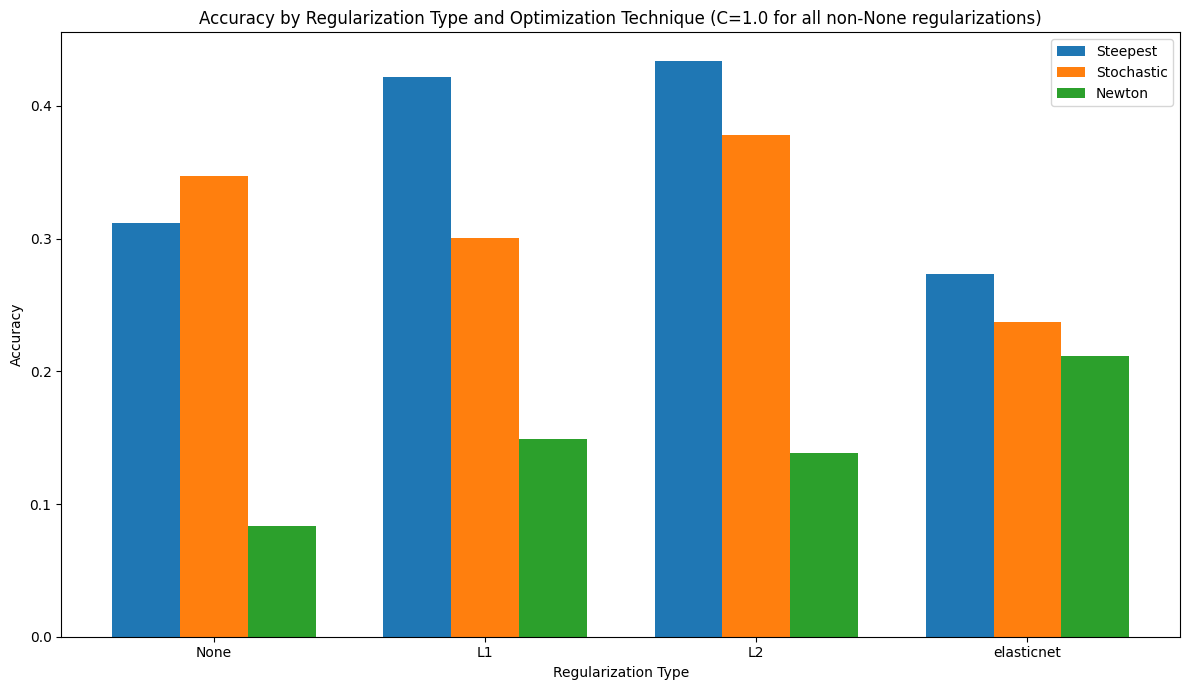

In [66]:
import numpy as np
import matplotlib.pyplot as plt

techniques = ['Steepest', 'Stochastic', 'Newton']
regularizations = ['None', 'L1', 'L2', 'elasticnet']

# Example data
accuracy_steepest = [0.3876, 0.3899, 0.4278, 0.2530]
accuracy_stochastic = [0.3266, 0.3192, 0.3713, 0.2433]
accuracy_newton = [0.0849, 0.1786, 0.1376, 0.1704]

accuracies = [accuracy_steepest, accuracy_stochastic, accuracy_newton]

# Setup the figure and axes
fig, ax = plt.subplots(figsize=(12, 7))

# Setting the positions and width for the bars
bar_width = 0.25
index = np.arange(len(regularizations))

# Plotting each technique's bars
for i, (tech, acc) in enumerate(zip(techniques, accuracies)):
    ax.bar(index + i*bar_width, acc, width=bar_width, label=tech)

# Configuring the plot
ax.set_xlabel('Regularization Type')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Regularization Type and Optimization Technique (C=1.0 for all non-None regularizations)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(regularizations)
ax.legend()

plt.tight_layout()
plt.show()


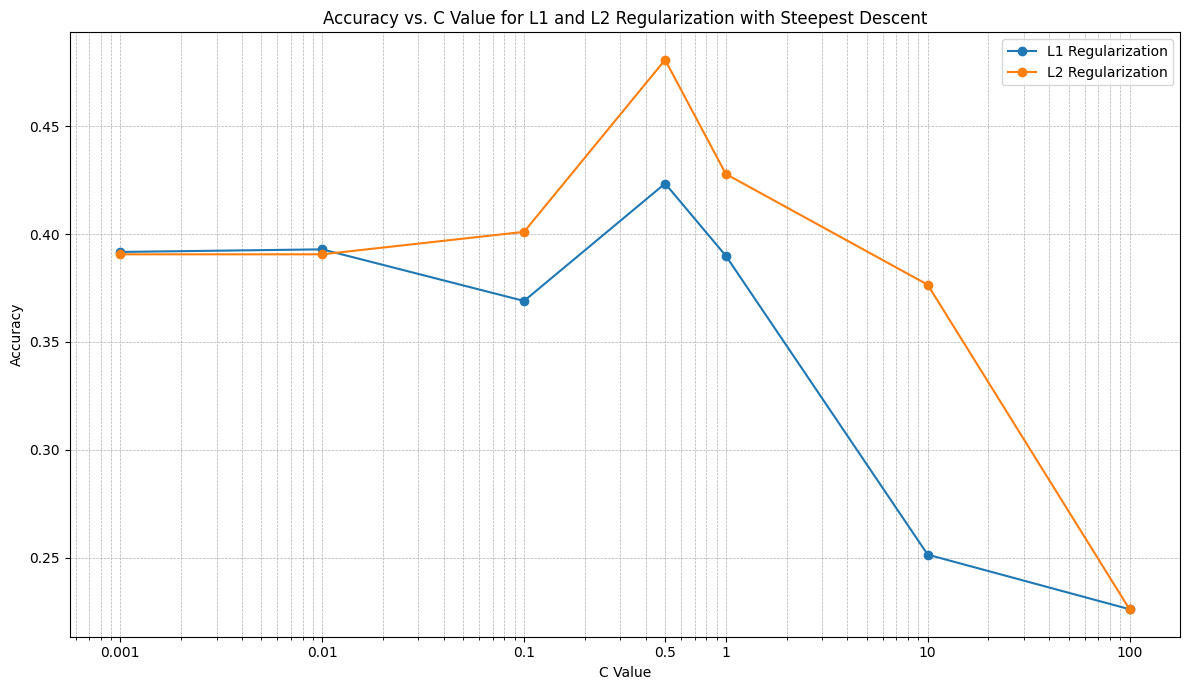

In [75]:
# C values and corresponding accuracies for L1 and L2
c_values = [0.001, 0.01, 0.1, 0.5, 1, 10, 100]

accuracy_l1 = [0.3917, 0.3929 , 0.3690 , 0.4234 , 0.3899 , 0.2515 , 0.2262]
accuracy_l2 = [0.3906, 0.3906 , 0.4010 , 0.4807 , 0.4278 , 0.3765 , 0.2262]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(c_values, accuracy_l1, marker='o', label='L1 Regularization')
plt.plot(c_values, accuracy_l2, marker='o', label='L2 Regularization')
plt.xscale('log')  # Log scale
plt.xticks(c_values, c_values)  # Set xticks to C values
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C Value for L1 and L2 Regularization with Steepest Descent')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### 2b3. Justification
Based on the first visualization, L1 or L2 regularization paired with the steepest ascent optimization provides the best accuracy. 

Based on the second visualization, we can see that for steepest ascent optimization, L1 and L2 regularizaiton perform best with an associated C value of 0.5 (with L2 performing slightly better).

### 2c. Comparing with Scikit-Learn

#### 2c1. Scikit-Learn implementation

In [76]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

In [77]:
lr = SKLogisticRegression(penalty='l2', C=0.5, solver='liblinear')

In [78]:
%%time
lr.fit(X_test, y_test)

yhat = lr.predict(X_test)

print('Accuracy of: ', accuracy_score(y_test, yhat))

Accuracy of:  0.5215773809523809
CPU times: total: 15.6 ms
Wall time: 13 ms


In [79]:
%%time
lr = LogisticRegression(eta=0.01, iterations=500, technique='steepest', regularization='l2', C=0.5)
lr.fit(X_test, y_test)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.4806547619047619
CPU times: total: 141 ms
Wall time: 141 ms


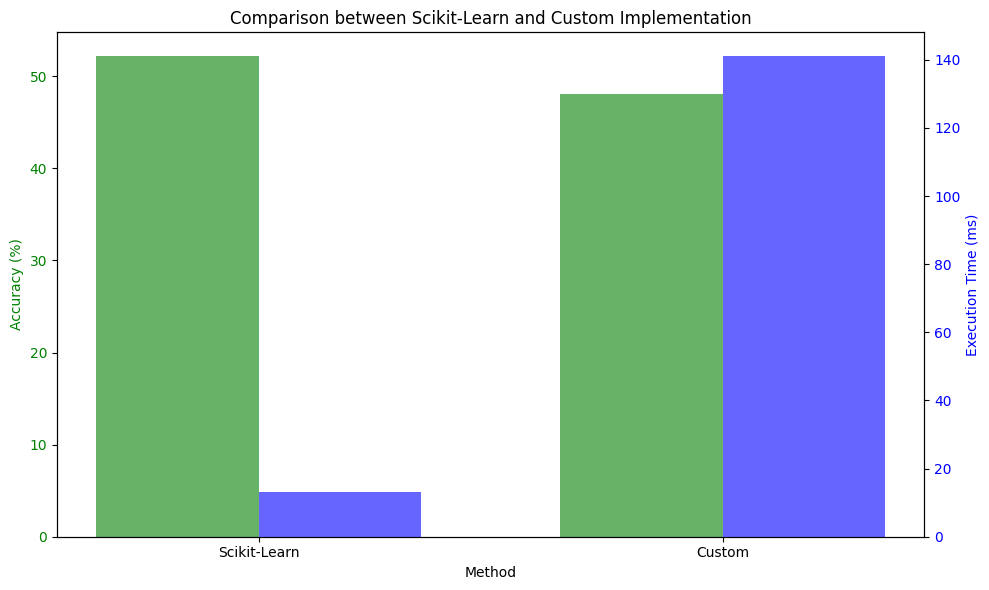

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['Scikit-Learn', 'Custom']
accuracy = [52.16, 48.07]
wall_time = [13, 141]  # in milliseconds

# Bar width
bar_width = 0.35
index = np.arange(len(methods))

# Create a figure and axis for accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy data
bars1 = ax1.bar(index, accuracy, bar_width, label='Accuracy (%)', color='g', alpha=0.6)
ax1.set_xlabel('Method')
ax1.set_ylabel('Accuracy (%)', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_title('Comparison between Scikit-Learn and Custom Implementation')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(methods)

# Create a second y-axis for wall time
ax2 = ax1.twinx()
bars2 = ax2.bar(index + bar_width, wall_time, bar_width, label='Execution Time (ms)', color='b', alpha=0.6)
ax2.set_ylabel('Execution Time (ms)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Legend
fig.tight_layout()

# Show the plot
plt.show()


As we can see, sklearn's accuracy was slightly better (50% to our custom implementation's 47%). Additionally, sklearn was approximatly 11 times faster. As we learned in class/the instructor notebook, sklearn better handles parallelization and conducts all operations in lower C++.

### 3. Deployment

I would definitley advise my clients to use an enterprise-level or industry standard tool (such as Scikit-Learn) over a home-grown or custom solution, especially for this theoretical application of this notebook (i.e., creating a model for a car company to help segment customers in a new market based on data from an established market.

Mainly this is because my custom implementation is far more likely to be incorrect or hard to scale compared to an industry standard tool such as sklearn. Also, for a car company to have the requisite knowledge to develop and maintain its own custom ML solutions, it would require they hire, train, and develop an internal staff that is capable of handling this kind of task. It would be much easier for a non-technical company to hire a consulting firm to develop an enterprise-grade/industry standardized solution that will be easier for them to maintain going forward.

### 4. 7000-level additional work

#### 4a. Option 1 (MSE objective function)

As I am not quite sure how to do this, I have gone to ChatGPT-4. You can find my conversation here: https://chat.openai.com/share/e027fb32-b033-40ee-8ad9-94009360eadc

In [95]:
class VectorBinaryLogisticRegressionMSE(VectorBinaryLogisticRegression):
    def _get_gradient(self, X, y):
        p = self.predict_proba(X, add_intercept=False).ravel()
        gradient = -np.mean(X * (y - p)[:, np.newaxis] * p[:, np.newaxis] * (1 - p)[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        
        # Add regularization to the gradient
        if self.regularization == 'l1':
            gradient[1:] += self.C * np.sign(self.w_[1:])
        elif self.regularization == 'l2':
            gradient[1:] += 2 * self.C * self.w_[1:]
        elif self.regularization == 'elasticnet':
            gradient[1:] += self.C * np.sign(self.w_[1:]) + 2 * self.C * self.w_[1:]

        return gradient
    
    def _get_hessian(self, X):
        p = self.predict_proba(X, add_intercept=False).ravel()
        W = np.diag(p * (1 - p))
        return X.T @ W @ X

As this is a new concept to me, I am not quite sure why I would do this at all. However, learning from ChatGPT (see above link to my conversation), I now understand that maximum likelihood estimation (MLE) is the standard objective function for logistic regression and using minimum MSE is unusual (but not out of the question).

An advantage to using MSE over MLE for logistic regression would be to have a more robust handling of outliers, and to avoid high computational complexity that could come with large datasets.